In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import paragami
import vittles

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 40
n_loci = 50
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

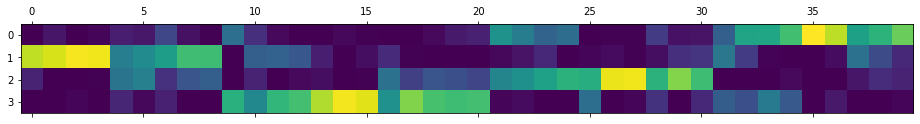

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(40, 50, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (40, 7, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 143241)

In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

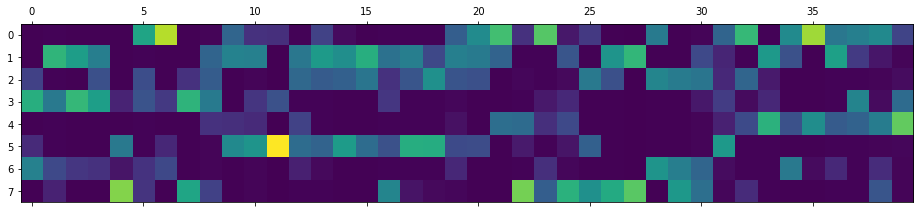

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

In [14]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            gh_loc, gh_weights)

DeviceArray(11000.2193286, dtype=float64)

# Run CAVI

In [15]:
vb_opt_dict, vb_opt, _, _ = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc, gh_weights = gh_weights, 
                        max_iter = 2000,
                        x_tol = 1e-4, 
                        print_every = 20)

# vb_opt_dict = vb_params_dict
# vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

CAVI compile time: 5.18sec

 running CAVI ...
iteration [20]; kl:3463.662612; elapsed: 0.1178secs
iteration [40]; kl:3423.774153; elapsed: 0.098secs
iteration [60]; kl:3392.048777; elapsed: 0.0655secs
iteration [80]; kl:3371.312255; elapsed: 0.0721secs
iteration [100]; kl:3365.915427; elapsed: 0.0772secs
iteration [120]; kl:3356.65813; elapsed: 0.1397secs
iteration [140]; kl:3354.657188; elapsed: 0.185secs
iteration [160]; kl:3354.379454; elapsed: 0.1633secs
iteration [180]; kl:3354.252382; elapsed: 0.1495secs
iteration [200]; kl:3354.17289; elapsed: 0.1267secs
iteration [220]; kl:3354.111512; elapsed: 0.0742secs
iteration [240]; kl:3354.054956; elapsed: 0.0682secs
iteration [260]; kl:3353.994528; elapsed: 0.0686secs
iteration [280]; kl:3353.921753; elapsed: 0.069secs
iteration [300]; kl:3353.82472; elapsed: 0.0671secs
iteration [320]; kl:3353.681961; elapsed: 0.0759secs
iteration [340]; kl:3353.447996; elapsed: 0.0674secs
iteration [360]; kl:3353.014127; elapsed: 0.0663secs
iteration 

In [16]:
(vb_opt**2).mean()

DeviceArray(3.82190997, dtype=float64)

In [17]:
# structure_model_lib.assert_optimizer(g_obs, vb_opt_dict, vb_params_paragami,
#                         prior_params_dict, gh_loc, gh_weights,
#                         use_logitnormal_sticks)


# Define objective

In [18]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: objective(g_obs, x, y, 
                                    gh_loc = gh_loc,
                                    gh_weights = gh_weights)

objective_fun_jitted = jax.jit(objective_fun)

In [19]:
def get_jac_hvp_fun(f):
    def hvp(x, v):
        return jax.jvp(jax.grad(f), (x, ), (v, ))[1]
    return hvp

In [20]:
# get derivative functions
obj_fun_grad = jax.jit(jax.grad(objective_fun, argnums = 0))
obj_fun_hessian = jax.jit(jax.hessian(objective_fun, argnums = 0))

obj_fun_hvp = jax.jit(get_jac_hvp_fun(lambda x : objective_fun(x, prior_params_free)))


# Derivative times

In [21]:
t0 = time.time()
loss = objective_fun_jitted(vb_opt, prior_params_free)
print('function compile time: {:0.3}sec'.format(time.time() - t0))

function compile time: 1.14sec


In [22]:
# function time
# %timeit objective_fun_jitted(vb_opt, prior_params_free)

In [23]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient compile time: {:0.3}sec'.format(time.time() - t0))

gradient compile time: 9.11sec


In [24]:
# gradient time
# %timeit obj_fun_grad(vb_opt, prior_params_free)

t0 = time.time()
_ = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 0.00055sec


In [25]:
# if its impossible, don't run the hessian
run_hessian = False

In [26]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

In [27]:
# cross hessian 
hyper_obj_fun_grad = jax.jit(jax.jacobian(objective_fun, argnums=1))
hyper_obj_cross_hess = jax.jit(jax.jacobian(hyper_obj_fun_grad, argnums=0))


In [28]:
t0 = time.time()
cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian compile time: {:0.3}sec'.format(time.time() - t0))

cross_hess = cross_hess.transpose()

cross-hessian compile time: 2.3sec


In [29]:
# %timeit hyper_obj_cross_hess(vb_opt, prior_params_free)

t0 = time.time()
_ = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian time: {:0.3}sec'.format(time.time() - t0))

cross-hessian time: 0.000438sec


In [30]:
# hessian-vector product time
t0 = time.time()
hvp = obj_fun_hvp(vb_opt, cross_hess[:, 0])
print('hvp compile time: {:0.3}sec'.format(time.time() - t0))

hvp compile time: 17.5sec


In [31]:
# %timeit obj_fun_hvp(vb_opt, cross_hess[:, 0])

t0 = time.time()
_ = obj_fun_hvp(vb_opt, cross_hess[:, 0])
print('hvp time: {:0.3}sec'.format(time.time() - t0))

hvp time: 0.00499sec


# Solver times

In [32]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))
    

In [33]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, x), 
                                            dim = len(vb_opt))

In [34]:
t0 = time.time()
_ = -cg_solver(cross_hess[:, 0])
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 0.451sec


In [35]:
# it seems like something is getting compiled, but 
# not sure what. Second time is faster
t0 = time.time()
dinput_dhyper2 = -cg_solver(cross_hess[:, 0])
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 0.451sec


In [36]:
# define preconditioner
precon_fun = jax.jit(lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_info = True))
t0 = time.time()
_ = precon_fun(cross_hess[:, 0])
print('preconditioner compile time: {:0.3}sec'.format(time.time() - t0))

preconditioner compile time: 1.32sec


In [37]:
M_op = osp.sparse.linalg.LinearOperator((len(vb_opt), len(vb_opt)), precon_fun)

# actual preconditioner time
%timeit M_op(cross_hess[:, 0])

2.34 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
cg_solver_precond = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, x), 
                                            dim = len(vb_opt), 
                                            cg_opts = {'M': M_op})
    
t0 = time.time()
dinput_dhyper3 = -cg_solver_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))



preconditioned solver time: 0.287sec


In [39]:
if run_hessian: 
    print(np.abs(dinput_dhyper[:, 0] - dinput_dhyper2).max())
    
print(np.abs(dinput_dhyper3 - dinput_dhyper2).max())

0.00017442079268370492


In [40]:
(dinput_dhyper2**2).mean()

1.1195294308214603